# Chapter 2: Roundoff Errors

Partly based on Matlab files for the book A First Course in Numerical Methods, by Ascher and Greif.

Julia version by Michael Friedlander and Itrat Ahmed Akhter.

In [2]:
using PyPlot

# Example 2.2 -- Figure 2.2
The roundoff error oscillates disorderly with high frequency as seen in the example below.

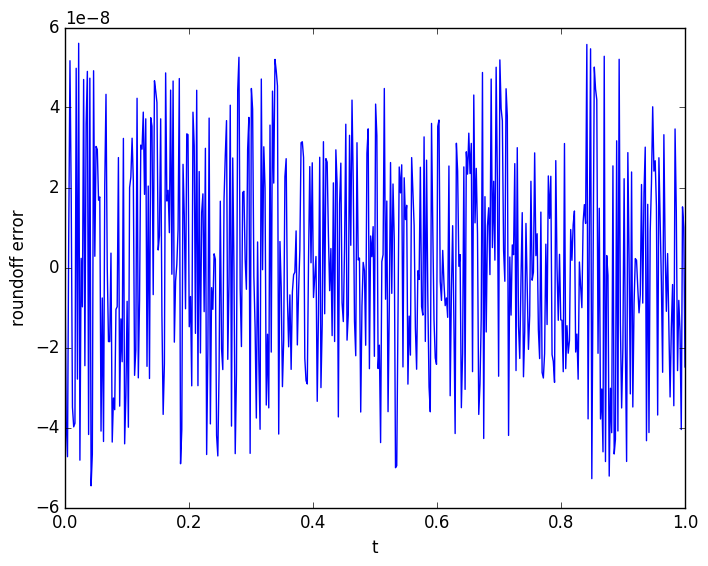

In [7]:
t = linspace(0,1,500)
round_err = []
for val in t
    ttval = exp(-val) * (sin(2*pi*val)+2)
    rtval = Float32(ttval)
    err = (ttval - rtval)/ttval
    push!(round_err,err)
end
plot(t,round_err,"b-")
xlabel("t")
ylabel("roundoff error");

The elative error should be about eta eps(Float32)/2:

In [8]:
rel_round_err = maxabs(round_err)/(eps(Float32)/2)
@printf "rel_round_err %f\n" rel_round_err

rel_round_err 0.940338


# Example 2.8 -- Figure 2.3
The floating point system is somewhat uneven when representing the real line. The following example shows this.

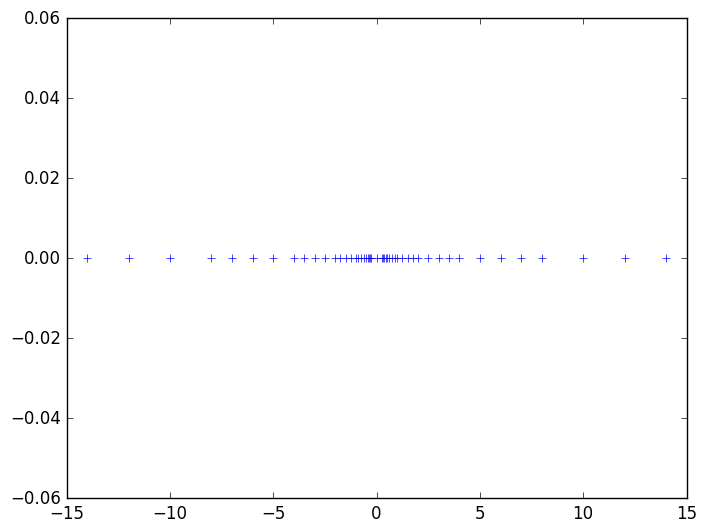

In [10]:
x = Float64[]

#Generate all positive numbers of the system (2,3,-2,3)
for i = 1:0.25:1.75
    for j = -2:3
        push!(x,i*(2.0^j))
    end
end

xcopy = copy(x)
for val in xcopy  #add all negative numbers
    push!(x,-val)
end

push!(x,0) #add 0
sort!(x)
y = zeros(x)
plot(x,y,"+");

Below is a function that returns values in $x$ rounded to $n$ decimal digits. Here, $n$ is less than the number of significant digits in $x$.

In [11]:
function roundc(x,n)
    #initialize fractions, exponents
    f = zeros(x)
    e = copy(f)
    #find nonzero components of x
    nz = find(x)
    xx = abs(x[nz])
    #decimal exponent of nonzero x
    e[nz] = ceil(log10(xx))
    #fraction of nonzero x
    f[nz] = xx ./ 10.^e[nz] 
    
    s = 1
    frac = zeros(x)
    for j = 1:n
        s = s*10
        d = floor(f*s + 0.5)  #extract digit
        f = f - d/s
        frac = frac + d/s    #add digit to rounded fraction
    end
    y = sign(x) .* (frac .* 10.^e);
    
    return y
end

x = [0.7342,0.7346]

y = roundc(x,3)
@printf "[%f %f]\n" y[1] y[2]

[0.734000 0.735000]


## Loss of significant digits

### Example 1
Evaluate
$$
    f(x) = x\left(\sqrt{x+1}-\sqrt x\right)
$$
for increasing values of $x$.

In [12]:
setprecision(1000)
f = x->x*(sqrt(x+1)-sqrt(x))
x0 = big"10.0"
x1 = Float64(10.0)
x2 = Float32(10.0)
x3 = Float16(10.0)
for i=0:8
    y0 = x0^i
    y1 = x1^i
    y2 = x2^i
    y3 = x3^i
    z0 = f(y0)
    z1 = f(y1)
    z2 = f(y2)
    z3 = f(y3)
    @printf("%5.0e: %15.5e  %15.5e  %15.5e  %15.5e\n",y0,z0,z1,z2,z3)
end;

1e+00:     4.14214e-01      4.14214e-01      4.14214e-01      4.14214e-01
1e+01:     1.54347e+00      1.54347e+00      1.54347e+00      1.54516e+00
1e+02:     4.98756e+00      4.98756e+00      4.98753e+00      4.98753e+00
1e+03:     1.58074e+01      1.58074e+01      1.58081e+01      1.35841e+01
1e+04:     4.99988e+01      4.99988e+01      4.99725e+01      4.99725e+01
1e+05:     1.58113e+02      1.58113e+02      1.58691e+02              NaN
1e+06:     5.00000e+02      5.00000e+02      4.88281e+02              NaN
1e+07:     1.58114e+03      1.58114e+03      2.44141e+03              NaN
1e+08:     5.00000e+03      5.00000e+03      0.00000e+00              NaN


Numerical cancelation in computing $\sqrt{x+1}-\sqrt{x}$ is the cause. For example, at $x=100$, let's compare the single-precision computation of
$$
\sqrt{x+1}-\sqrt{x} = \sqrt{101}-\sqrt{100}.
$$
against the "exact" computation.

In [19]:
ef = sqrt(big"101")-sqrt(big"100")
af = sqrt(Float16(101)) - sqrt(Float64(100))
@printf "   Exact: %15.6e\n"  ef
@printf "Computed: %15.6e\n"  af

   Exact:    4.987562e-02
Computed:    4.687500e-02


Thus, this calculation has **loss of significant error**. In particular, 2 digits of accuracy were lost in the subtraction. We need to find a way to reformulate the offending calculation. Here's a useful identity (see Example 2.11 of the text):
$$
\sqrt{x+1}-\sqrt{x}
\equiv
\frac{(\sqrt{x+1}-\sqrt{x})(\sqrt{x+1}+\sqrt{x})}{\sqrt{x+1}+\sqrt{x}}
=
\frac{1}{\sqrt{x+1}+\sqrt{x}}.
$$

In [20]:
f = x->(x/(sqrt(x+1)+sqrt(x)))
for i=0:8
    y0 = x0^i
    y1 = x1^i
    y2 = x2^i
    y3 = x3^i
    z0 = f(y0)
    z1 = f(y1)
    z2 = f(y2)
    z3 = f(y3)
    @printf("%5.0e: %15.5e  %15.5e  %15.5e  %15.5e\n",y0,z0,z1,z2,z3)
end

1e+00:     4.14214e-01      4.14214e-01      4.14214e-01      4.14214e-01
1e+01:     1.54347e+00      1.54347e+00      1.54347e+00      1.54351e+00
1e+02:     4.98756e+00      4.98756e+00      4.98756e+00      4.98756e+00
1e+03:     1.58074e+01      1.58074e+01      1.58074e+01      1.58069e+01
1e+04:     4.99988e+01      4.99988e+01      4.99987e+01      4.99987e+01
1e+05:     1.58113e+02      1.58113e+02      1.58113e+02              NaN
1e+06:     5.00000e+02      5.00000e+02      5.00000e+02              NaN
1e+07:     1.58114e+03      1.58114e+03      1.58114e+03              NaN
1e+08:     5.00000e+03      5.00000e+03      5.00000e+03              NaN


Note the improved accuracy.

### Example 2
Evaluate $$f(x)=\frac{1-\cos(x)}{x^2}$$
for a sequence $x\to0$.

In [24]:
f = x->((1-cos(x))/x^2)
ex = big"10.0"
ax = Float32(10.0)
for i in -1:-1:-5
    ef = f(ex^i)
    af = f(ax^i)
    @printf("%-5f  %15.6e  %15.6e\n",ex^(i),af,ef)
end

0.100000     4.995823e-01     4.995835e-01
0.010000     5.000830e-01     4.999958e-01
0.001000     4.768371e-01     5.000000e-01
0.000100     0.000000e+00     5.000000e-01
0.000010     0.000000e+00     5.000000e-01


The culprit is cancellation in the term $1-\cos(x)$:

In [26]:
ax = Float32(0.01)
ex = big"0.01"
@printf "      Exact: %15.6e\n" 1-cos(ex)
@printf "Approximate: %15.6e\n" 1-cos(ax)

      Exact:    4.999958e-05
Approximate:    5.000830e-05


To avoid loss of significant digits because nearly equal quantities are being subtracted, use Taylor's approximation of $\cos$ at $x=0$:
$$
\cos(x) = 1 - \frac{x^2}{2!} + \frac{x^4}{4!} - \frac{x^6}{6!} + \frac{x^8}{8!}\cos(\xi)\quad \xi\in(0,x).
$$
Then,
\begin{align*}
  f(x) &= \frac{1}{x^2}\left\{1 - \left[1 - \frac{x^2}{2!} + \frac{x^4}{4!} - \frac{x^6}{6!} + \frac{x^8}{8!}\cos(\xi)\right] \right\}.
\\ &= \frac{1}{2!} - \frac{x^2}{4!} + \frac{x^4}{6!} - \frac{x^6}{8!}\cos(\xi).
\end{align*}
We know that the exact answer is $f(0)=1/2$. Thus, for $|x|\le10^{-1}$, the remainder term tells us the discretization error:
$$
\left|
\frac{x^6}{8!}\cos(\xi)
\right|
\left|
\frac{x^6}{8!}
\right|
\le\frac{10^{-6}}{8!}=2.5\cdot10^{-11},
$$
which gives the accuracy of the approximation for $|x|\le10^{-1}$.

Here's the revised table, using this approximation.

In [27]:
f = x->(1/2 - x^2/(factorial(4)) + x^4/factorial(6))
ex = big"10.0"
ax = Float32(10.0)
for i in -1:-1:-5
    ef = f(ex^i)
    af = f(ax^i)
    @printf("%-5f  %15.6e  %15.6e\n",ex^(i),af,ef)
end

0.100000     4.995835e-01     4.995835e-01
0.010000     4.999958e-01     4.999958e-01
0.001000     5.000000e-01     5.000000e-01
0.000100     5.000000e-01     5.000000e-01
0.000010     5.000000e-01     5.000000e-01
